**Loading the Libraries**

In [1]:
%matplotlib inline

import numpy as np  
import pandas as pd
from time import time

import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import kernel_approximation
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

import seaborn as sns

rcParams['figure.figsize'] = 15, 5

**Loading the dataset**

In [2]:
data = pd.read_csv('No-show-Issue-Comma-300k.csv')
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


**Dataset size**

In [3]:
print("Data size:", len(data))

Data size: 300000


**Each column unique vsalues**

In [4]:
for column in list(data.columns):
    print("{0:25} {1}".format(column, data[column].nunique()))

Age                       109
Gender                    2
AppointmentRegistration   295425
ApointmentData            534
DayOfTheWeek              7
Status                    2
Diabetes                  2
Alcoolism                 2
HiperTension              2
Handcap                   5
Smokes                    2
Scholarship               2
Tuberculosis              2
Sms_Reminder              3
AwaitingTime              213


**Function to plot the frequency of the data of each column**

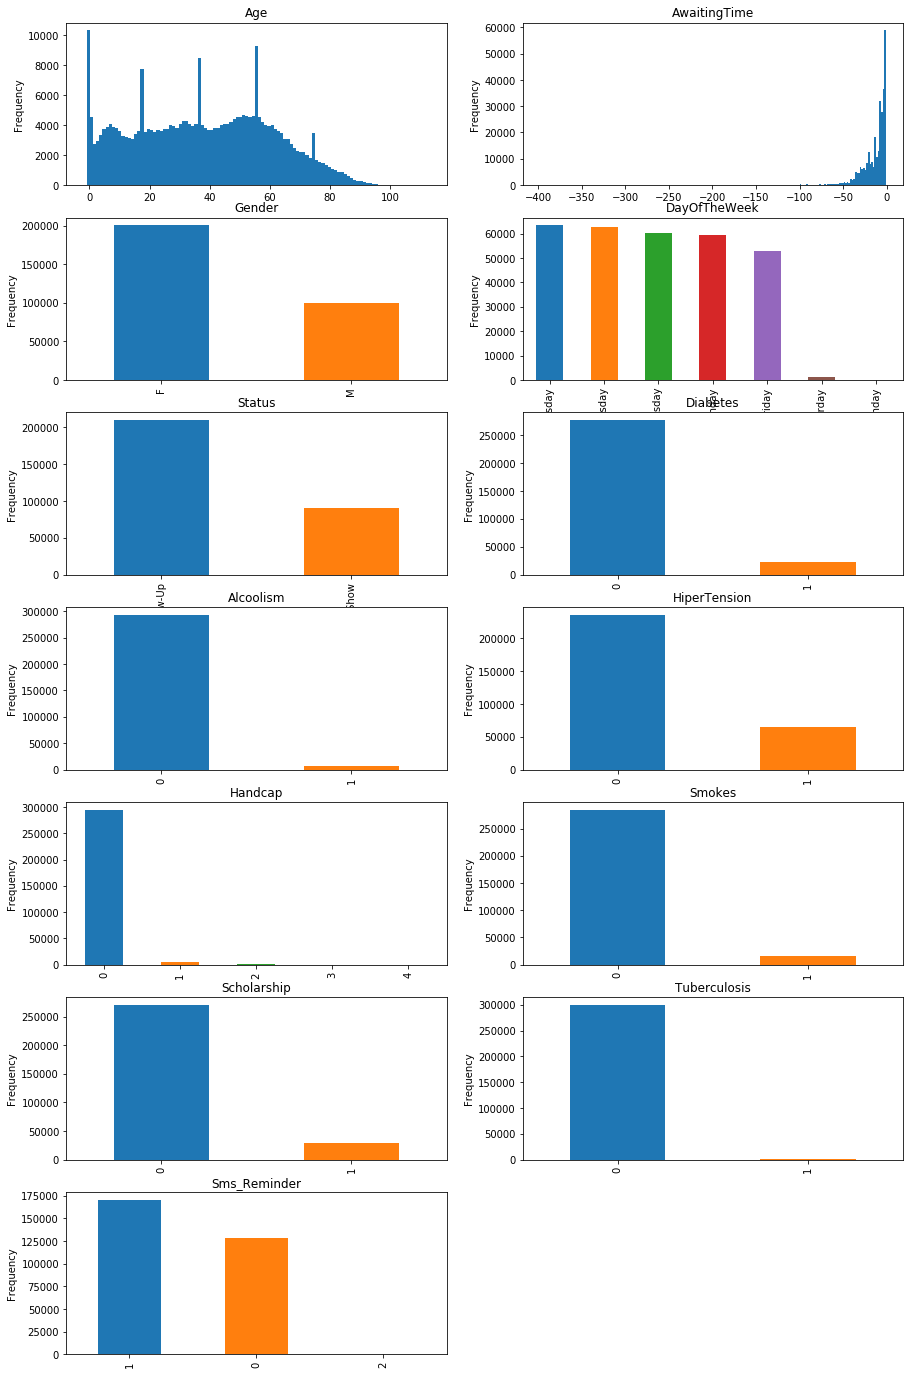

In [5]:
def features_plots(discrete_vars):
    plt.figure(figsize=(15, 24.5))
    for i, cv in enumerate(['Age', 'AwaitingTime']):
        plt.subplot(7, 2, i+1)
        plt.hist(data[cv], bins=len(data[cv].unique()))
        plt.title(cv)
        plt.ylabel('Frequency')
    
    for i, dv in enumerate(discrete_vars):
        plt.subplot(7, 2, i+3)
        data[dv].value_counts().plot(kind='bar', title=dv)
        plt.ylabel('Frequency')
        
discrete_vars=['Gender', 'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoolism',
               'HiperTension', 'Handcap', 'Smokes','Scholarship', 
               'Tuberculosis', 'Sms_Reminder']
features_plots(discrete_vars)

**Removing the age column values that are less than zero**

In [8]:
# data[data['Age'] < 0].value_counts().sum()
data = data[data['Age'] >=0]

**Deleting the column named handcap**

In [9]:
del data['Handcap']
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,1,15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,1,6


**Converting the negative awating time values to positive values**

In [10]:
data['AwaitingTime'] = data['AwaitingTime'].apply(lambda x: abs(x))

**Encoding the DayOfTheWeek column values into numbers**

In [11]:
dow_mapping = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2,
              'Thursday' : 3, 'Friday' : 4, 'Saturday' : 5, 'Sunday' : 6}
data['DayOfTheWeek'] = data['DayOfTheWeek'].map(dow_mapping)
print(data['DayOfTheWeek'])

0         2
1         2
2         1
3         3
4         1
5         1
6         1
7         4
8         1
9         1
10        0
11        3
12        0
13        0
14        3
15        3
16        0
17        3
18        0
19        2
20        5
21        4
22        3
23        4
24        1
25        0
26        3
27        3
28        2
29        4
         ..
299970    2
299971    3
299972    0
299973    3
299974    4
299975    2
299976    2
299977    4
299978    1
299979    2
299980    1
299981    1
299982    4
299983    3
299984    2
299985    1
299986    3
299987    2
299988    1
299989    3
299990    4
299991    1
299992    0
299993    1
299994    4
299995    2
299996    1
299997    4
299998    3
299999    2
Name: DayOfTheWeek, Length: 299994, dtype: int64


**Converting the columns of Gender and status into a categorical columns**

In [12]:
for field in ['Gender', 'Status']:
    data[field] = pd.Categorical(data[field]).codes

**Exracting and plotting the discrete values columns**

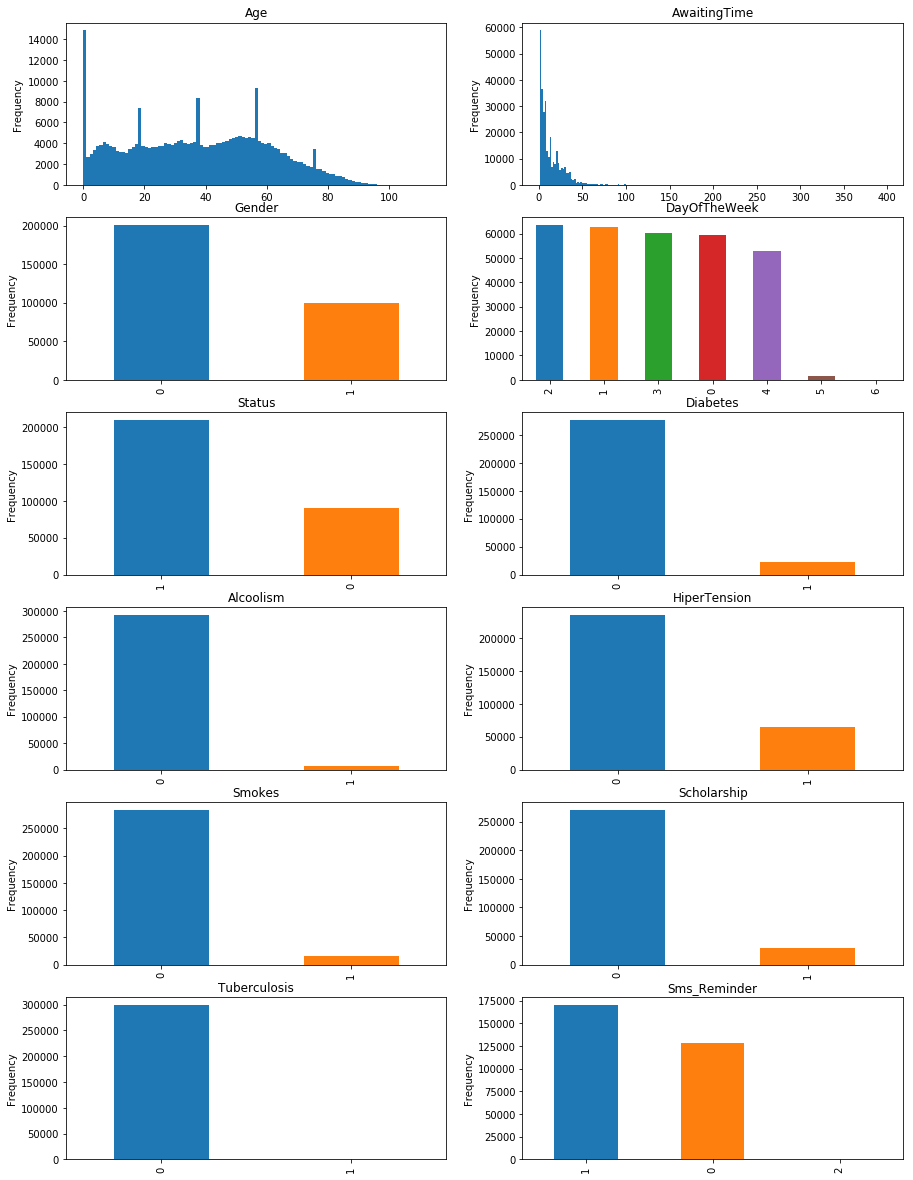

In [13]:
discrete_vars=['Gender', 'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoolism',
               'HiperTension', 'Smokes','Scholarship', 
               'Tuberculosis', 'Sms_Reminder']
features_plots(discrete_vars)

**Here us the scatter graph of the Age and Awating time columns**

(0, 120)

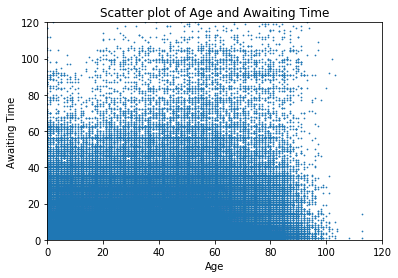

In [14]:
plt.scatter(data['Age'], data['AwaitingTime'], s=0.5)
plt.title('Scatter plot of Age and Awaiting Time')
plt.xlabel('Age')
plt.ylabel('Awaiting Time')
plt.xlim(0, 120)
plt.ylim(0, 120)

**Here is the coorelations of the Age and Awaiting Time column** 

In [17]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
correlations = data[['Age', 'AwaitingTime']].corr(method='pearson')
print(correlations)

                Age  AwaitingTime
Age           1.000        -0.004
AwaitingTime -0.004         1.000


**Here is the bar graph of the 'Sms_Reminder' with respect to the 'Status'**

Text(0,0.5,'Frequency')

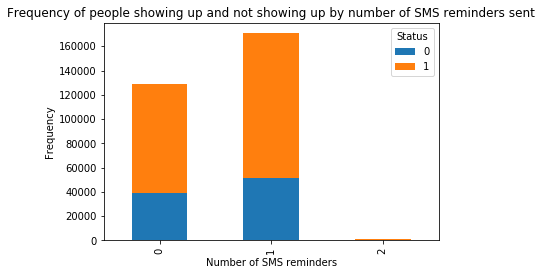

In [18]:
data_dow_status = data.groupby(['Sms_Reminder', 'Status'])['Sms_Reminder'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by number of SMS reminders sent')
plt.xlabel('Number of SMS reminders')
plt.ylabel("Frequency")

**Here is the bar grph of the 'DayOfTheWeek' wiht respect to the 'Status' column**

Text(0,0.5,'Frequency')

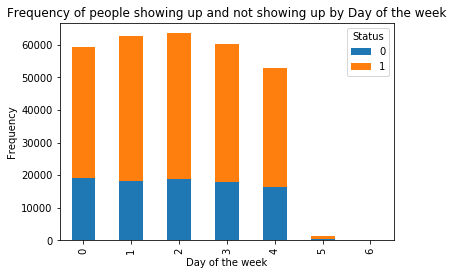

In [19]:
data_dow_status = data.groupby(['DayOfTheWeek', 'Status'])['DayOfTheWeek'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by Day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Frequency')

**Here we are creating a boxplot of the column Age with respect to the status**

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


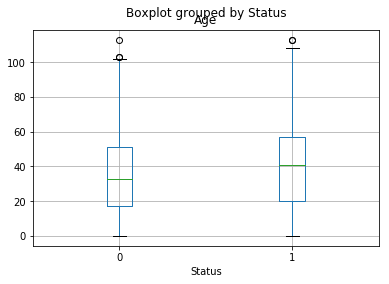

In [20]:
data.boxplot(column=['Age'], return_type='axes', by='Status')
plt.show()

**Here we are displaying the patient show up with respect to the gender**

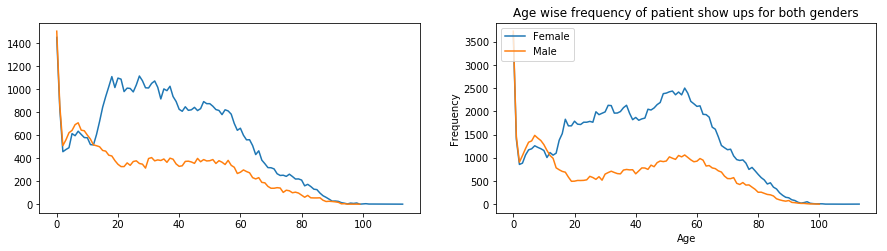

In [21]:
plt.figure(figsize=(15, 3.5))
for i, status in enumerate(['no show ups', 'show ups']):
    data_show = data[data['Status']==i]
    plt.subplot(1, 2, i+1)
    
    for gender in [0, 1]:
        data_gender = data_show[data_show['Gender']==gender]
        freq_age = data_gender['Age'].value_counts().sort_index()
        freq_age.plot()
    
plt.title('Age wise frequency of patient %s for both genders'%status)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['Female', 'Male'], loc='upper left')


**Here are the box plot of the "Awating time" with respect to the "Status"**

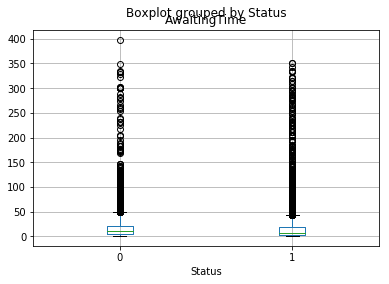

In [22]:
data.boxplot(column=['AwaitingTime'], return_type='axes', by='Status')
plt.show()

**Here are we applying the data wranglling on the 'AppointmentRegistration' and 'ApointmentData' columns and creating nine new columns**
* AppointmentRegistration_year
* AppointmentRegistration_month
* AppointmentRegistration_day
* ApointmentData_year
* ApointmentData_month
* ApointmentData_day
* AppointmentRegistration_hour
* AppointmentRegistration_min
* AppointmentRegistration_sec

In [23]:
for col in ['AppointmentRegistration', 'ApointmentData']:
    for index, component in enumerate(['year', 'month', 'day']):
        data['%s_%s'%(col, component)] = data[col].apply(lambda x:int(x.split('T')[0].split('-')[index]))

In [24]:
for index, component in enumerate(['hour', 'min', 'sec']):
    data['%s_%s'%('AppointmentRegistration', component)] = data['AppointmentRegistration'].apply(lambda x: int(x.split('T')[1][:-1].split(':')[index]))

In [25]:
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Smokes,...,AwaitingTime,AppointmentRegistration_year,AppointmentRegistration_month,AppointmentRegistration_day,ApointmentData_year,ApointmentData_month,ApointmentData_day,AppointmentRegistration_hour,AppointmentRegistration_min,AppointmentRegistration_sec
0,19,1,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,2,1,0,0,0,0,...,29,2014,12,16,2015,1,14,14,46,25
1,24,0,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,2,1,0,0,0,0,...,1,2015,8,18,2015,8,19,7,1,26
2,4,0,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,1,1,0,0,0,0,...,1,2014,2,17,2014,2,18,12,53,46
3,5,1,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,3,1,0,0,0,0,...,15,2014,7,23,2014,8,7,17,2,11
4,38,1,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,1,1,0,0,0,0,...,6,2015,10,21,2015,10,27,15,20,9


**Here following is the function to evaluate the model performance**

In [30]:
def model_performance(model_name, X_train, y_train, y_test, Y_pred):
    print('Model name: %s'%model_name)
    print('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(y_test, Y_pred))
    print('Test accuracy (ROC AUC Score): %f'%metrics.roc_auc_score(y_test, Y_pred))
    print('Train accuracy: %f'%clf.score(X_train, y_train))
    fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
    print( 'Area Under the Precision-Recall Curve: %f'%metrics.auc(fpr, tpr))
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, Y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(model_name + "ROC_Curve.jpg")
    plt.show()
    
# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(predictions, y_test_set, model_name):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
    print ("\nClassification report : \n", classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True, fmt='g',cmap='viridis')
    plt.tight_layout()
    plt.savefig(model_name + "_confusion matrix.jpg")
    plt.show()
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions, average='macro'),
              recall_score(y_test_set, predictions, average='macro'),f1_score(y_test_set, predictions, average='macro')]
    return results

**Here are we seperating the features and the target columns and splitting the dataset into train and test data**

In [31]:
features_of_choice = [u'Age', u'Gender', 'DayOfTheWeek', 'Diabetes','Alcoolism', 'HiperTension',
                      'Smokes', 'Scholarship', 'Tuberculosis','Sms_Reminder',
                      'AwaitingTime', 'AppointmentRegistration_year','AppointmentRegistration_month',
                      'AppointmentRegistration_day', 'ApointmentData_year', 'ApointmentData_month','ApointmentData_day', 'AppointmentRegistration_hour', 'AppointmentRegistration_min',
                      'AppointmentRegistration_sec']
x = np.array(data[features_of_choice])
y = np.array(data['Status'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)

**Here are we applying the Decision tree Classifier**

In [32]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

**Making predictions and evaluating the model**

Model name: Decision tree classifier
Test accuracy (Accuracy Score): 0.589907
Test accuracy (ROC AUC Score): 0.524310
Train accuracy: 0.999952
Area Under the Precision-Recall Curve: 0.112913


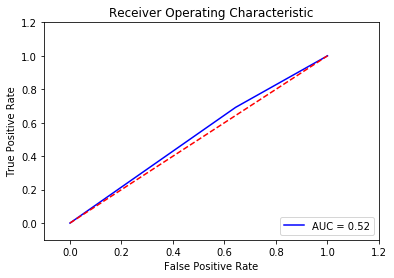

========== Decision tree ==========

Accuracy on validation set: 0.5891

Classification report : 
               precision    recall  f1-score   support

           0       0.34      0.36      0.35     27394
           1       0.71      0.69      0.70     62605

   micro avg       0.59      0.59      0.59     89999
   macro avg       0.52      0.52      0.52     89999
weighted avg       0.60      0.59      0.59     89999


Confusion Matrix : 
 [[ 9752 17642]
 [19339 43266]]


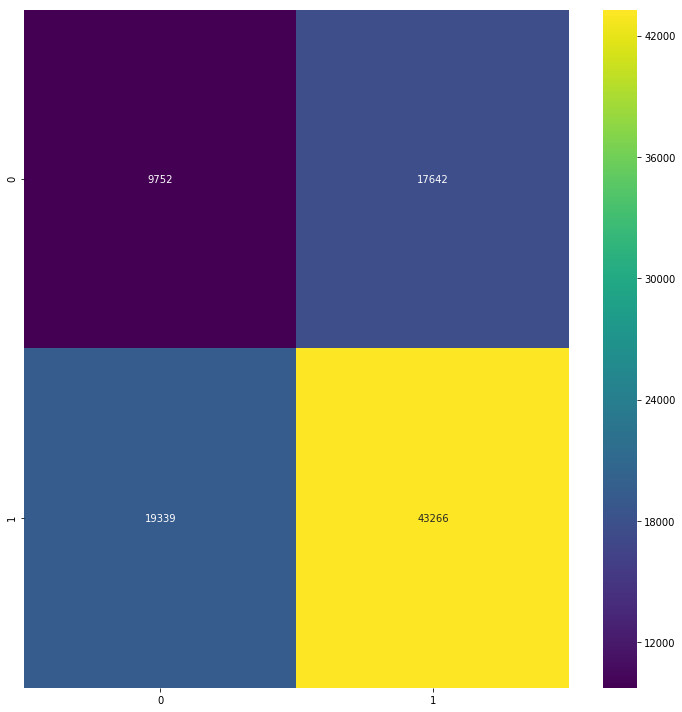

In [33]:
y_pred = clf.predict(x_test)
model_performance('Decision tree classifier', x_train, y_train, y_test,y_pred)

# For Decision tree Classifier
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
pred_dt = dt_model.predict(x_test)
result_dt = modelEvaluation(pred_dt, y_test, 'Decision tree')

**Here we using another machine learning algorithm called the Stocastic Grdient Descent**

In [34]:
rbf_feature = kernel_approximation.RBFSampler(gamma=1, random_state=1)
X_train = rbf_feature.fit_transform(x_train)
clf = SGDClassifier()
clf.fit(X_train, y_train)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

**Here is the SGD Classifier model Evaluation results**

Model name: Kernel approximation
Test accuracy (Accuracy Score): 0.695619
Test accuracy (ROC AUC Score): 0.500000
Train accuracy: 0.698398
Area Under the Precision-Recall Curve: 0.152191


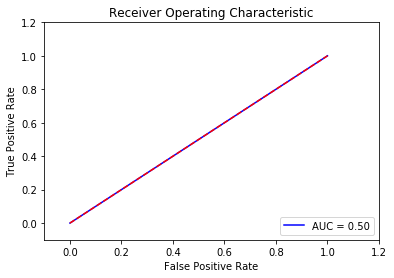

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


========== SGDClassifier ==========

Accuracy on validation set: 0.6955

Classification report : 
               precision    recall  f1-score   support

           0       0.39      0.00      0.00     27394
           1       0.70      1.00      0.82     62605

   micro avg       0.70      0.70      0.70     89999
   macro avg       0.54      0.50      0.41     89999
weighted avg       0.60      0.70      0.57     89999


Confusion Matrix : 
 [[   22 27372]
 [   35 62570]]


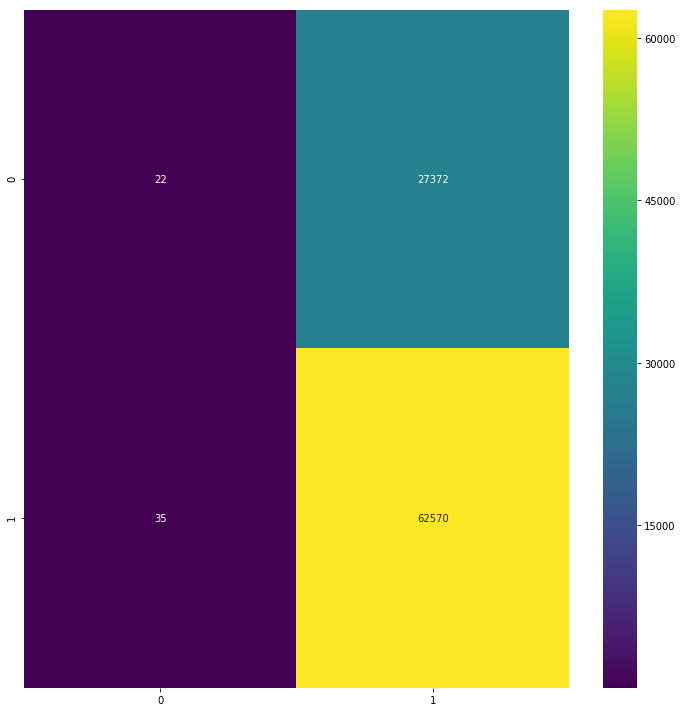

In [35]:
X_test = rbf_feature.fit_transform(x_test)
Y_pred = clf.predict(X_test)
model_performance('Kernel approximation', X_train, y_train, y_test, Y_pred)

# For SGD Classifier
sgd_model = SGDClassifier()
sgd_model.fit(x_train, y_train)
pred_sgd = sgd_model.predict(x_test)
result_sgd = modelEvaluation(pred_sgd, y_test, 'SGDClassifier')

**Here is the Gradient Boosteing Model Application**

In [36]:
clf = GradientBoostingClassifier(random_state=10, learning_rate=0.1,n_estimators=200, max_depth=5, max_features=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

Model name: Gradient Boosting
Test accuracy (Accuracy Score): 0.700408
Test accuracy (ROC AUC Score): 0.514929
Train accuracy: 0.707403
Area Under the Precision-Recall Curve: 0.153744


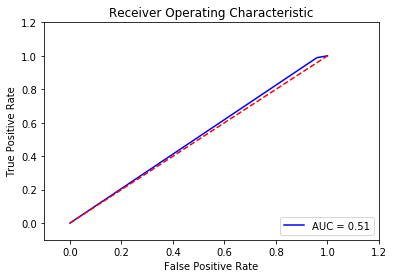

========== Gradient Boosting ==========

Accuracy on validation set: 0.7004

Classification report : 
               precision    recall  f1-score   support

           0       0.62      0.04      0.08     27394
           1       0.70      0.99      0.82     62605

   micro avg       0.70      0.70      0.70     89999
   macro avg       0.66      0.51      0.45     89999
weighted avg       0.68      0.70      0.59     89999


Confusion Matrix : 
 [[ 1119 26275]
 [  688 61917]]


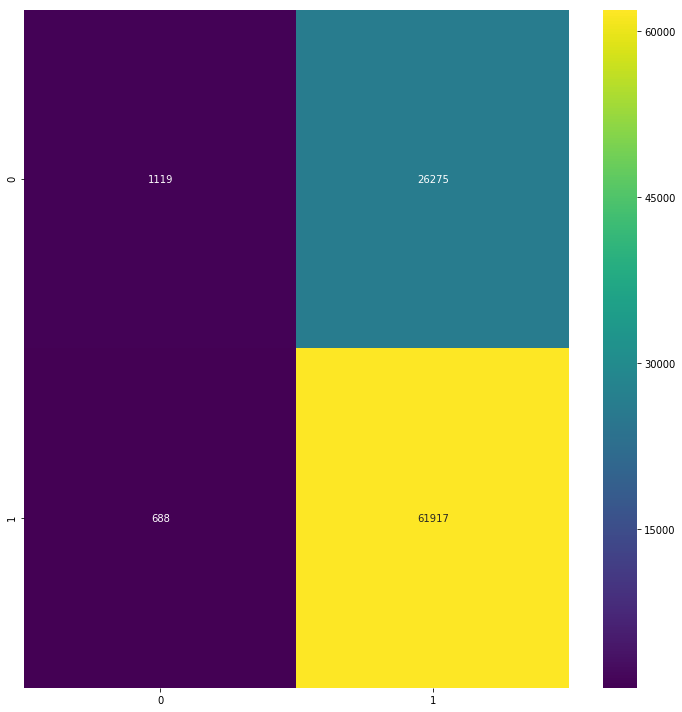

In [37]:
model_performance('Gradient Boosting', x_train, y_train, y_test, y_pred)

# For GradientBoosting Classifier
gb_model = GradientBoostingClassifier(random_state=10, learning_rate=0.1,n_estimators=200, max_depth=5, max_features=10)
gb_model.fit(x_train, y_train)
pred_gb = gb_model.predict(x_test)
result_gb = modelEvaluation(pred_gb, y_test, 'Gradient Boosting')

**Here is the feature importance of all the columns**

In [38]:
for feature, score in zip(features_of_choice, list(clf.feature_importances_)):
    print('%s\t%f'%(feature, score))

Age	0.285653
Gender	0.006518
DayOfTheWeek	0.044685
Diabetes	0.003152
Alcoolism	0.014895
HiperTension	0.006151
Smokes	0.018705
Scholarship	0.014370
Tuberculosis	0.001326
Sms_Reminder	0.042174
AwaitingTime	0.194542
AppointmentRegistration_year	0.021316
AppointmentRegistration_month	0.025876
AppointmentRegistration_day	0.033952
ApointmentData_year	0.015311
ApointmentData_month	0.050646
ApointmentData_day	0.081603
AppointmentRegistration_hour	0.060791
AppointmentRegistration_min	0.040959
AppointmentRegistration_sec	0.037376


**Models Comparisons**

In [39]:
from tabulate import tabulate
# showing all models result
dic = {
    'Metrics':['accuracy','precision','recall','f1-score'],
    'Decision tree' : result_dt,
    'SGD Classifier': result_sgd,
    'Gradient Boosting Classifier' : result_gb
}
metrics_df = pd.DataFrame(dic)

metrics_df = metrics_df.set_index('Metrics')
# displaying the DataFrame
print(tabulate(metrics_df, headers = 'keys', tablefmt = 'psql'))

+-----------+-----------------+------------------+--------------------------------+
| Metrics   |   Decision tree |   SGD Classifier |   Gradient Boosting Classifier |
|-----------+-----------------+------------------+--------------------------------|
| accuracy  |        0.589095 |         0.695474 |                       0.700408 |
| precision |        0.522787 |         0.540818 |                       0.660664 |
| recall    |        0.523543 |         0.500122 |                       0.514929 |
| f1-score  |        0.522943 |         0.41097  |                       0.448919 |
+-----------+-----------------+------------------+--------------------------------+


**Comprisons Graphs**

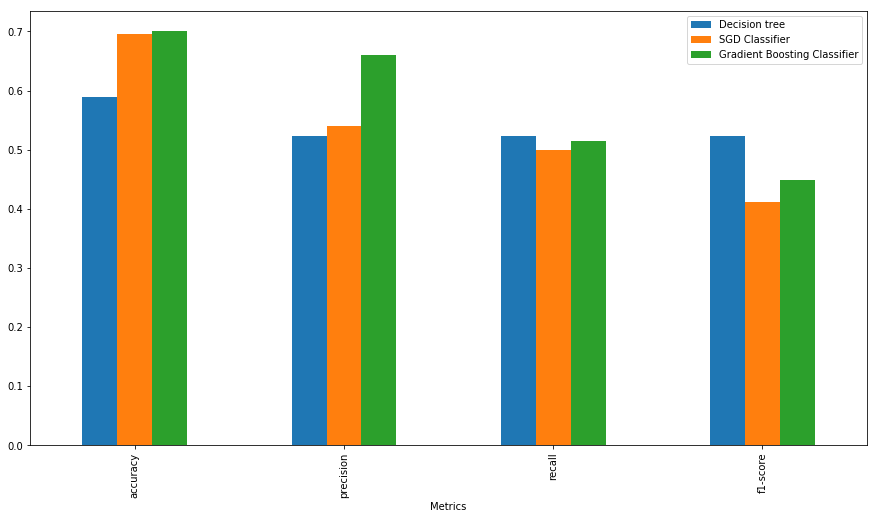

In [40]:
metrics_df.plot(kind='bar', figsize=(15,8))
plt.savefig("Model_Comparisons_Graph.jpg")
plt.show()

**Model Accuracies Comparisons**

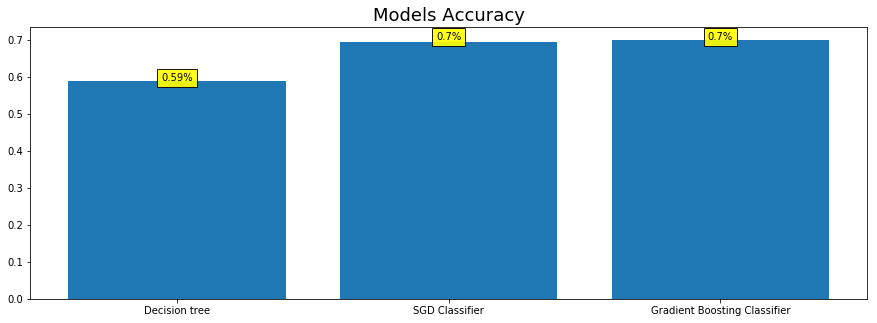

In [41]:
models_acc = metrics_df.iloc[0].tolist()
models_names = metrics_df.columns.tolist()
plt.figure(figsize=(15,5))
plt.bar(models_names,models_acc)
plt.title("Models Accuracy", fontsize=18)

def addLabels(names,acc):
    for i in range(len(names)):
        plt.text(i,round(acc[i],2),f"{round(acc[i],2)}%", ha = 'center', bbox=dict(facecolor='yellow', alpha=0.9))

addLabels(models_names,models_acc)
plt.savefig("Model_Accuracies_Comparisons_Graph.jpg")
plt.show()